<a href="https://colab.research.google.com/github/BIGMOUSSA/image_classification_from_intel_image/blob/main/Intel_image_classifcation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pour telecharger les données via l'API kaggle, connectez vous avec sur kaggle et telecharger (profil---Account---create new api token .
c'est fichier kaggle.json qu'il faudra coller sur la machine virtual de collabe

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
# Importations des données depuis Kaggle
!kaggle datasets download -d puneet6060/intel-image-classification

 98% 340M/346M [00:04<00:00, 92.9MB/s]
100% 346M/346M [00:04<00:00, 83.5MB/s]


In [ ]:
!unzip \*.zip && rm *.zip

In [ ]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import plotly.express as px
#from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array 
from tensorflow.keras.preprocessing import image
# import ImageDataGenerator, img_to_array 

from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.utils import img_to_array



In [ ]:
INPUT_SHAPE = (150,150,3)
BATCH_SIZE = 60
test_path='/content/seg_test/seg_test/'
train_path='/content/seg_train/seg_train'



In [ ]:
directory=os.listdir(test_path)
directory

['sea', 'glacier', 'buildings', 'forest', 'mountain', 'street']

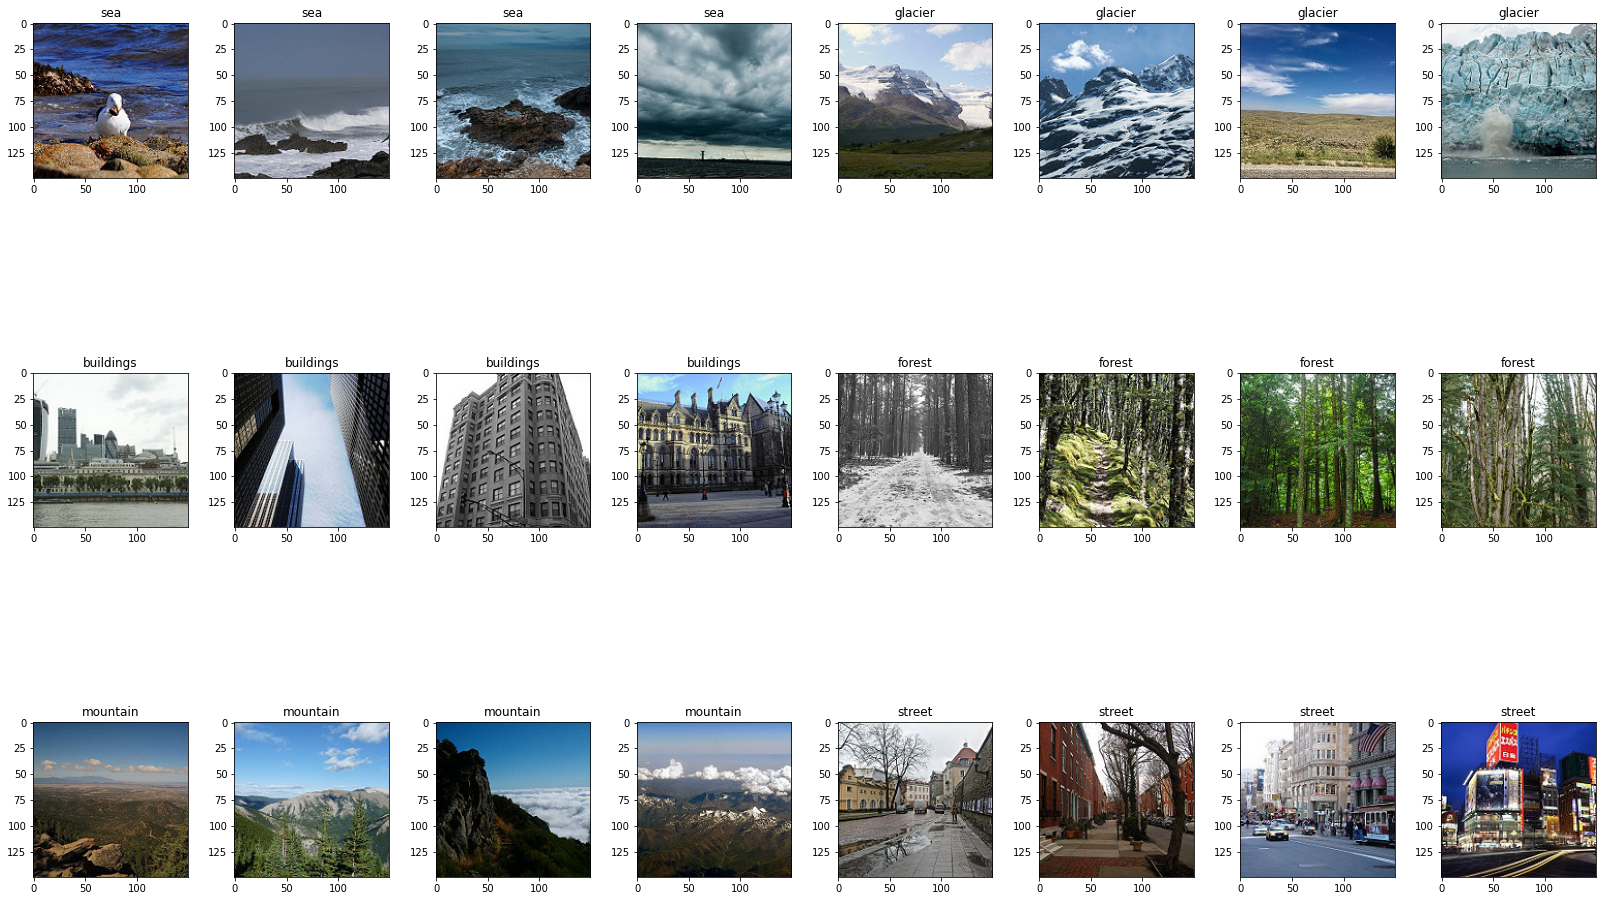

In [ ]:
def visualize_data(folder):
    c=1
    directory=os.listdir(folder)
    plt.figure(figsize=(28,20))
    for each in directory:
        currentFolder=folder+ "/" +each
        for i, file in enumerate(os.listdir(currentFolder)[0:4]):
            full_path=currentFolder+"/"+file
            plt.subplot(3, 8, c)
            img = mpimg.imread(full_path)
            plt.imshow(img)
            plt.title(each)
            c+=1
    plt.subplots_adjust(wspace=0.3, hspace=-0.1)
    plt.show()
    
visualize_data(test_path)
#/content/seg_test/seg_test/glacier

Récuperation des images et transformation en np.array qui seront stockées dans un list

In [ ]:
def makelab(folder):
    directory=os.listdir(folder)
    label=[]
    img_array=[]
    for each in directory:
        currentFolder=folder+ "/" +each
        for i, file in enumerate(os.listdir(currentFolder)):
            full_path=currentFolder+"/"+file
            img = mpimg.imread(full_path)
            if tf.keras.utils.img_to_array(img).shape==(150,150,3):
              label.append(each)
              img_array.append(tf.keras.utils.img_to_array(img))
              
    return label,img_array

In [ ]:
lab, im = makelab(test_path)

In [ ]:
im[0].shape

(150, 150, 3)

In [ ]:
print('number of samples: ', len(lab))
print('image shape: ', im[0].shape)
print('labels:', np.unique(lab))

number of samples:  2993
image shape:  (150, 150, 3)
labels: ['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


In [ ]:
X = np.array(im)
y = np.array(lab)

In [ ]:
count=0
for i in im:
  if i.shape != (150, 150, 3):
    im.remove(i)
  
print(count)
    

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.


In [ ]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

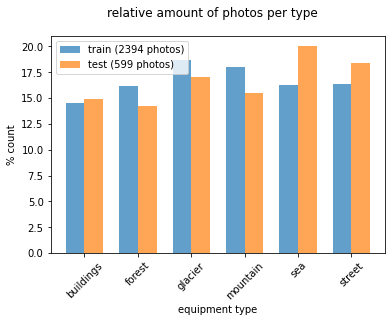

In [ ]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from skimage import color
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(12, 12),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage

 
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(10, 10), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(2394, 7056)


In [ ]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(random_state=42)

In [ ]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

In [ ]:
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

[ True  True False  True False  True  True  True  True  True False  True
  True False  True False  True  True  True False  True  True False False
  True]

Percentage correct:  65.27545909849749


### confusion matrix

In [ ]:
import pandas as pd

In [ ]:
from sklearn.metrics import confusion_matrix
 
label_names = ['yes', 'no']
cmx = confusion_matrix(labels, predictions, labels=label_names)
df = pd.DataFrame(cmx, columns=label_names, index=label_names)
df.columns.name = 'prediction'
df.index.name = 'label'
df

prediction,yes,no
label,,
yes,4,2
no,1,3


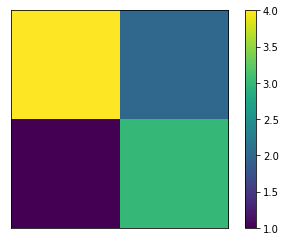

In [ ]:
plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar();

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
 
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(10, 10), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
])
 
clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))

Percentage correct:  65.27545909849749


In [ ]:
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(10, 10), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SVC())
])
 
clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))

Percentage correct:  72.62103505843072


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(10, 10), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', KNeighborsClassifier(n_neighbors=6))
])
 
clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))

Percentage correct:  38.06343906510851


In [ ]:
#sklearn.ensemble.AdaBoostClassifier(base_estimator=None, *, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None)[source]¶
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier,RandomForestClassifier


In [ ]:
#adaBoost
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(10, 10), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', AdaBoostClassifier())
])
 
clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))

Percentage correct:  49.58263772954925


In [ ]:
#Bagging
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(10, 10), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', BaggingClassifier())
])
 
clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))

Percentage correct:  48.080133555926544


In [ ]:
#Gradient
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(10, 10), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', GradientBoostingClassifier())
])
 
clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))

Percentage correct:  68.2804674457429


In [ ]:
#HistGrad
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(10, 10), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', HistGradientBoostingClassifier())
])
 
clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))

In [ ]:
#Random
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(10, 10), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', RandomForestClassifier())
])
 
clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))

## APPROCHE DEEP LEARNING CNN

In [ ]:
X_train_hog.shape

(19, 2916)

In [ ]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import plotly.express as px
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

In [ ]:
def get_generator(_training_dir, _test_dir):
    train_datagen = ImageDataGenerator(
        rescale=1/255.0, 
        featurewise_center=True,
        featurewise_std_normalization=True, 
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        shear_range=0.2,
        fill_mode='nearest'
    )
    test_datagen = ImageDataGenerator(
        rescale=1/255.0
    )
    train_generator = train_datagen.flow_from_directory(
        _training_dir,
        shuffle=True,
        target_size=(150,150),
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    test_generator = test_datagen.flow_from_directory(
        _test_dir,
        shuffle=True,
        target_size=(150,150),
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    
    return train_generator, test_generator

In [ ]:
train_generator, test_generator = get_generator(train_path, test_path)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
train_generator.labels

array([0, 0, 0, ..., 5, 5, 5], dtype=int32)

In [ ]:
train_generator

In [ ]:
def get_initialized_model(INPUT_SHAPE):
    base_model = InceptionResNetV2(
        input_shape=INPUT_SHAPE,
        weights='imagenet',
        include_top=False,
        pooling='avg'
    )
    base_model.trainable = False
    
    print('Base Model Ouput Shape = {}'.format(base_model.output_shape))
    last_output = base_model.output
    x = tf.keras.layers.Dropout(0.2)(last_output)
    x = tf.keras.layers.Dense(units=128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(units=128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(units = 6, activation='softmax')(x)
    
    model = tf.keras.Model( base_model.input, x) 

    model.compile(
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001, momentum=0.9, centered=True), 
        loss = ['categorical_crossentropy'], 
        metrics = ['accuracy']
    )

    model_callback = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        min_delta=0.001, 
        patience=5, 
        verbose=1,
        mode='auto', 
        baseline=None, 
        restore_best_weights=True
    ), tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=1,
        min_delta=0.0000001,
        verbose=1 
    )]
    
    return model, model_callback

In [ ]:
model, model_callbacks = get_initialized_model(INPUT_SHAPE)

219070464/219055592 [==============================] - 2s 0us/step
Base Model Ouput Shape = (None, 1536)


In [ ]:
history = model.fit_generator(train_generator, epochs=30, validation_data=test_generator, callbacks=[model_callbacks])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/30
234/234 [==============================] - 1458s 6s/step - loss: 0.7132 - accuracy: 0.7380 - val_loss: 0.3285 - val_accuracy: 0.8790 - lr: 1.0000e-04
Epoch 2/30
234/234 [==============================] - ETA: 0s - loss: 0.5262 - accuracy: 0.8065
Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
234/234 [==============================] - 1403s 6s/step - loss: 0.5262 - accuracy: 0.8065 - val_loss: 0.3352 - val_accuracy: 0.8637 - lr: 1.0000e-04
Epoch 3/30
 14/234 [>.............................] - ETA: 18:34 - loss: 0.5751 - accuracy: 0.8095

KeyboardInterrupt: ignored

In [ ]:
def plotter(history):
    #summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
score = model.evaluate_generator(test_generator)
plotter(history)
print('\nScore [ {} ] '.format(dict(zip(model.metrics_names, score))))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


NameError: ignored

In [ ]:
import joblib
from skimage.io import imread
from skimage.transform import resize
 
def resize_all(src, pklname, include, width=150, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
     
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1})animal images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        #if subdir in include:
        print(subdir)
        current_path = os.path.join(src, subdir)

        for file in os.listdir(current_path):
            if file[-3:] in {'jpg', 'png'}:
                im = imread(os.path.join(current_path, file))
                im = resize(im, (width, height)) #[:,:,::-1]
                data['label'].append(subdir[:-4])
                data['filename'].append(file)
                data['data'].append(im)

        joblib.dump(data, pklname)

In [ ]:
base_name = 'animal_faces'
width = 80
 
include = {'ChickenHead', 'BearHead', 'ElephantHead', 
           'EagleHead', 'DeerHead', 'MonkeyHead', 'PandaHead'}
 
resize_all(src=data_path, pklname=base_name, width=width, include=include)

In [ ]:
im[0].shape

(150, 150, 3)

In [ ]:
len(lab)

24

In [ ]:
x_test.shape

NameError: ignored

In [ ]:
np.array(im).T.reshape(3, 150, 150).T

ValueError: ignored

In [ ]:
import numpy as np
x_test = np.array(im)
x_test[0].shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


(150, 150, 3)

In [ ]:
x_test.shape

(3000,)

In [ ]:
width, height, channels = x_test.shape[1], x_test.shape[2], 1
x_test = x_test.reshape((x_test.shape[0], width, height, channels))
#testX = testX.reshape((testX.shape[0], width, height, channels))
#trainY = to_categorical(trainY)
from keras.utils import to_categorical
testY = to_categorical(lab)

ValueError: ignored

# PREPARATION DES DONNEES
to do :
- étiquetter les images 
- convertir les images en array
-  construire un pipeline pour un modele de machine learning avec scikit learn (PCA + une méthode classique (SVM par exemple)

# ENTRAINER LE MODELE / SCORING / TUNING ETC

# ESSAYER AVEC LA METHODE CNN